In [ ]:
!nvidia-smi

Sat Jul  3 23:16:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import numpy as np

# check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 1
batch_size = 64
valid_size = 0.2

# turn our data into vectors and normalize
transform_test = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5])
                                ])
transform_train = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5])
                                ])

# load the data
train_data = datasets.CIFAR10('data', train=True, download=True, 
                              transform=transform_train)
test_data = datasets.CIFAR10('data', train=False, download=True, 
                             transform=transform_test)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           sampler=valid_sampler,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           num_workers=num_workers)

# specify classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
  img = img / 2 + 0.5 # unnormalize? idk
  plt.imshow(np.transpose(img, (1, 2, 0)))

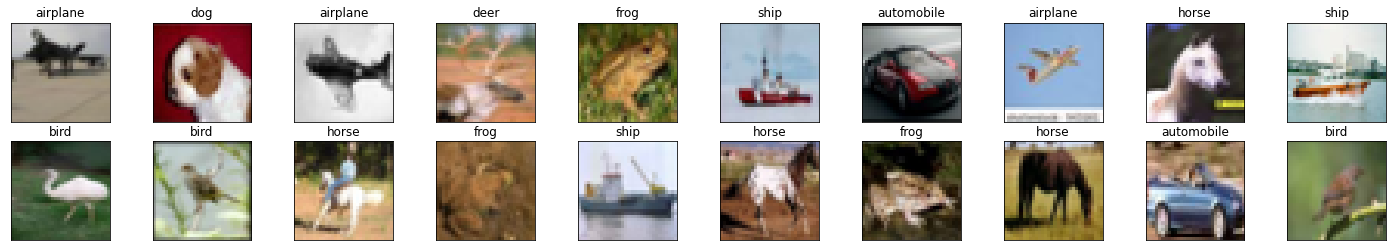

In [ ]:
dataiter = iter(train_loader)
data, target = dataiter.next()
data = data.numpy()

fig = plt.figure(figsize=(25, 4))
for x in np.arange(20):
  ax = fig.add_subplot(2, 20/2, x+1, xticks=[], yticks=[])
  imshow(data[x])
  ax.set_title(classes[target[x]])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    # (in, out, kernel size, optargs)
    # conv1 sees 32x32x8
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    # conv2 sees 16x16x16
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    # conv3 sees 8x8x32
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

    # max pooling layers take stack of feature maps, returns lower dimension
    self.pool = nn.MaxPool2d(2, 2) # this will half the dims x,y

    self.norm = nn.LayerNorm(1024)
    self.fc1 = nn.Linear(1024, 500)
    self.fc2 = nn.Linear(500, 10)

    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.pool(F.gelu(self.conv1(x)))
    x = self.pool(F.gelu(self.conv2(x)))
    x = self.pool(F.gelu(self.conv3(x)))

    x = x.view(x.shape[0], -1)

    x = self.norm(x)
    x = self.dropout(x)
    x = F.gelu(self.fc1(x))
    x = self.dropout(x)
    x = F.log_softmax(self.fc2(x), dim=1)

    return x

In [ ]:
import torch.optim as optim

model = ConvNet()
model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=3E-4)

# scaler for mixed precision
scaler = torch.cuda.amp.GradScaler()

valid_loss_min = np.Inf

epochs = 100
epochs_since_last_save = 0

for epoch in range(epochs):
  train_loss = 0.0
  valid_loss = 0.0

  model.train() # put it in train mode
  for data, target in train_loader:
    optimizer.zero_grad() # always zero grad

    # move params to gpu
    data = data.to(device)
    target = target.to(device)

    with torch.cuda.amp.autocast():
      output = model(data)
      loss = criterion(output, target)
    
    # backprop, rad grad desk ent
    scaler.scale(loss).backward()
    scaler.step(optimizer)

    scaler.update()

    train_loss += loss.item() * data.size(0)

  model.eval() # eval mode for analyzing
  with torch.no_grad(): # so it doesnt autograd
    for data, target in valid_loader:
      # move our tensors to the jeeps
      data = data.to(device)
      target = target.to(device)

      with torch.cuda.amp.autocast():
        output = model(data)
        loss = criterion(output, target)
      
      valid_loss += loss.item() * data.size(0)

  valid_loss = valid_loss / len(valid_loader.dataset)
  train_loss = train_loss / len(train_loader.dataset)
  epochs_since_last_save += 1

  print( "----------------------------------------------\n"
        f"Epoch: {epoch + 1}/{epochs} \n"
        f"Training Loss: {train_loss: .4f} \n"
        f"validation Loss: {valid_loss: .4f}\n")
  
  if valid_loss <= valid_loss_min:
    print("Validation Loss Decreased! Saving Model.")
    torch.save(model.state_dict(), "model.pt")
    valid_loss_min = valid_loss
    epochs_since_last_save = 0

  print(f"Epochs Since Last Save: {epochs_since_last_save}")

  if epochs_since_last_save > 6:
    print("Losses seem to have diverged. Stopping Training.")
    break

----------------------------------------------
Epoch: 1/100 
Training Loss:  1.1516 
validation Loss:  0.2306

Validation Loss Decreased! Saving Model.
Epochs Since Last Save: 0
----------------------------------------------
Epoch: 2/100 
Training Loss:  0.8736 
validation Loss:  0.1949

Validation Loss Decreased! Saving Model.
Epochs Since Last Save: 0
----------------------------------------------
Epoch: 3/100 
Training Loss:  0.7533 
validation Loss:  0.1834

Validation Loss Decreased! Saving Model.
Epochs Since Last Save: 0
----------------------------------------------
Epoch: 4/100 
Training Loss:  0.6726 
validation Loss:  0.1709

Validation Loss Decreased! Saving Model.
Epochs Since Last Save: 0
----------------------------------------------
Epoch: 5/100 
Training Loss:  0.6079 
validation Loss:  0.1637

Validation Loss Decreased! Saving Model.
Epochs Since Last Save: 0
----------------------------------------------
Epoch: 6/100 
Training Loss:  0.5496 
validation Loss:  0.1611


In [ ]:
# load best model
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
test_loss = 0.0
accuracy = 0.0

model.eval()
with torch.no_grad():
  for data, target in test_loader:
    # putta da data toda gee pee you
    data = data.to(device)
    target = target.to(device)

    # pre the dick
    output = model.forward(data)
    loss = criterion(output, target)

    test_loss += loss.item() * data.size(0)

    # calc acc
    ps = torch.exp(output)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == target.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

  print(f"Test Loss: {test_loss / len(test_loader.dataset): .4f}\n"
        f"Accuracy: {(accuracy / len(test_loader)) * 100 : .2f}%")

Test Loss:  0.3577
Accuracy:  90.04%


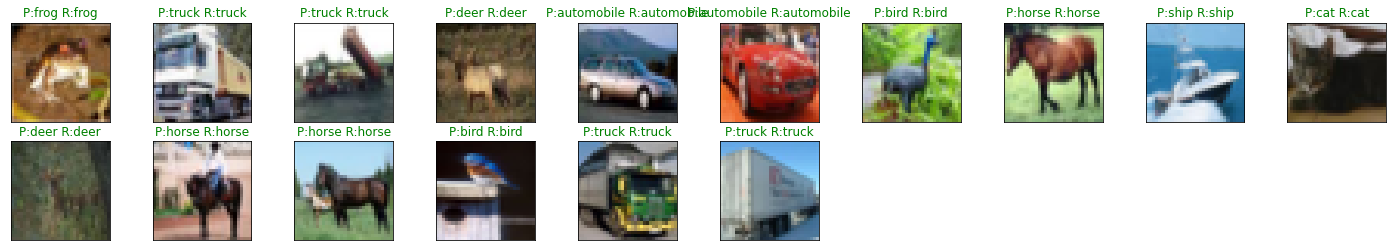

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()
model.to('cpu')

images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1) # conv proba to pred
preds = np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize=(25, 4))
for index in np.arange(16):
  ax = fig.add_subplot(2, 20/2, index + 1, xticks=[], yticks=[])
  imshow(images[index].cpu())
  ax.set_title(f"P:{classes[preds[index]]} R:{classes[labels[index]]}",
               color=("green" if preds[index] == labels[index].item() else "gray"))